In [44]:
import pandas as pd
import transformers 
import numpy as np
import torch
from collections import OrderedDict
import seaborn as sns

import sys

sys.path.insert(0, '..')

from roberta_model import RobertaConfig
from decompose_roberta import RobertaForSequenceClassificationDecomposed, decomp_activation


In [45]:
tokenizer = transformers.AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

state_dict = transformers.AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels= 3).state_dict()

new_state_dict = OrderedDict()
for key, value in state_dict.items():
    # rename weight values in state_dict from roberta to bert
    new_key = key.replace("roberta", "bert")
    new_key = new_key.replace(
        "classifier.dense", "bert.pooler.dense").replace(
            "classifier.out_proj", "classifier")
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = new_key.replace("LayerNorm.weight",
                           "LayerNorm.gamma").replace("LayerNorm.bias",
                                                       "LayerNorm.beta")
    new_state_dict[new_key] = value

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
config = RobertaConfig.from_json_file("config.json")
decomposed_model = RobertaForSequenceClassificationDecomposed(
    config=config,
    debug=False, 
    num_labels=3
    )

decomposed_model.model.load_state_dict(new_state_dict)
decomposed_model.model.eval()

RobertaForSequenceClassification(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): RobertaLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): RobertaLayerNorm()
              (dropout): Dropout(p=

In [64]:
model = decomposed_model.model

# text = "I was amazed by how boring it was."
# text = "It is a very strange film... and I mean that as a compliment."
# text = "While the intention is easy to admire, the execution remains disappointing."
text = "I respect the visuals, I respect the performances but... nah."
encoded_input = tokenizer(text, return_tensors='pt')['input_ids']

with torch.no_grad():
    output = model(encoded_input)
    print(output.shape)
    scores = torch.softmax(output, 1)
scores

torch.Size([1, 3])


tensor([[0.2082, 0.5893, 0.2025]], dtype=torch.float64)

In [65]:
tokenizer.tokenize(text, add_special_tokens=True)

words = []
probabilities = torch.zeros(3, len(encoded_input.squeeze()))
logits = torch.zeros(3, len(encoded_input.squeeze()))
links = []

for i in range(len(encoded_input.squeeze())):
    span = tokenizer(text, return_tensors='pt').token_to_chars(i)
    if span:
        words.append(text[span.start: span.end])
    else:
        words.append(tokenizer.convert_ids_to_tokens(encoded_input[:,i])[0])
    mask = torch.zeros_like(encoded_input.squeeze())
    mask[i] = 1
    
    beta_mask = torch.stack([mask, 1 - mask]).unsqueeze(0)

    with torch.no_grad():
        l = decomposed_model(input_ids=encoded_input,
                        beta_mask=beta_mask,
                        num_contributions=2).squeeze()
        probs = torch.softmax(l[0], 0)
        total_probs = torch.softmax(l.sum(0), 0)
        print(l.sum(0))

    probabilities[:, i] = probs
    logits[:, i] = l[0]

probabilities

tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)
tensor([-0.4527,  0.5879, -0.4806], dtype=torch.float64)


tensor([[0.4107, 0.2592, 0.2867, 0.3111, 0.4848, 0.3166, 0.3258, 0.3194, 0.3274,
         0.3092, 0.2956, 0.3642, 0.4340, 0.3814, 0.3198, 0.3326],
        [0.3892, 0.2977, 0.3153, 0.3294, 0.0698, 0.3345, 0.3269, 0.3247, 0.3324,
         0.3279, 0.3212, 0.3315, 0.3210, 0.3256, 0.3337, 0.0787],
        [0.2000, 0.4431, 0.3980, 0.3594, 0.4454, 0.3490, 0.3473, 0.3559, 0.3403,
         0.3630, 0.3833, 0.3044, 0.2449, 0.2930, 0.3465, 0.5887]])

In [66]:
links = []
labels = ["negative", "neutral", "positive"]
colors = {
    "negative": "rgba(0, 202, 255, 0.5)",
    "neutral": "rgba(112, 255, 145, 0.5)",
    "positive": "rgba(255, 0, 250, 0.3)"
}

for i, a in enumerate(zip(words, logits.T.tolist())):
    word, logit = a
    for j, b in enumerate(zip(labels, logit)):
        label, v = b
        links.append(
            {
                'source': i,
                'target': len(words) + j,
                'value': v,
                'color': colors[label]
            }
        )

In [67]:
import plotly.graph_objects as go
df = pd.DataFrame(links)

fig = go.Figure(
    go.Sankey(
        # arrangement = "snap", 
        node={"label": words + labels,
              'x': [0.1] * len(words) + [0.5] * len(labels),
              "y": list(np.linspace(0.01,0.99,len(words))) + list(np.linspace(0.01,0.99,len(labels))),
              'color': "grey",
            #   'pad':10
              },
            #   "y": [],
        link={
            "source": df["source"].tolist(),
            "target": df["target"].tolist(),
            "value": df["value"].tolist(),
            "color": df["color"].tolist(),
        },
    )
)

fig.show()

In [68]:
data = df.copy()
data["word"] = data["source"].apply(lambda x: words[x])
data["target"] = data["target"].apply(lambda x: labels[x - len(words)])

data = data.pivot_table(index=["source", "word"], columns="target", values="value").reset_index().set_index("word").drop(columns=["source"])

# data.loc["__TOTAL__"] = [sum(data["negative"]), sum(data["neutral"]), sum(data["positive"])]
data

target,negative,neutral,positive
word,,,
<s>,0.229710,0.175937,-0.489654
I,-0.229111,-0.090616,0.306902
respect,-0.150865,-0.055826,0.177039
the,-0.069960,-0.012924,0.074349
visuals,0.338682,-1.599626,0.253785
",",-0.057322,-0.002223,0.040111
I,-0.026058,-0.022835,0.037558
respect,-0.053395,-0.036932,0.054933
the,-0.020533,-0.005398,0.018201


<Figure size 1200x600 with 0 Axes>

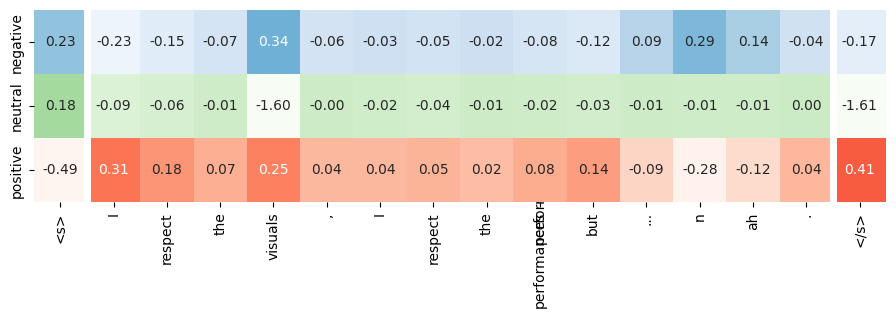

In [69]:
import matplotlib.pyplot as plt

cm = ['Blues', 'Greens', 'Reds']

plt.figure(figsize=(12, 6))
f, axs = plt.subplots(3, 1, gridspec_kw={'hspace': 0},  figsize=(11, 2.5))

counter = 0
for index, row in data.T.iterrows():
    ax = sns.heatmap(np.array([row.values]), yticklabels=[labels[counter]], xticklabels=data.T.columns, annot=True, fmt='.2f', ax=axs[counter], cmap=cm[counter], cbar=False, vmin=-0.3, vmax=1, linecolor="black")
    ax.axvline(x=1, linewidth=5, color="w")
    ax.axvline(x=len(words) - 1, linewidth=5, color="w")
    counter += 1

plt.show()

In [70]:
with torch.no_grad():
    second_last_embeddings = model.bert(encoded_input, output_all_encoded_layers=True)[0][10]
    print(second_last_embeddings.shape)

# create component split before the last transformer layer
# split each token into a component

new_split = torch.stack([second_last_embeddings] * 3)
print(new_split.shape)

torch.Size([1, 16, 768])
torch.Size([3, 1, 16, 768])


In [71]:
import itertools
num_contributions = 2

perms = torch.tensor(list(itertools.permutations(torch.arange(num_contributions))))

In [72]:
last_tf_layer = decomposed_model.bert_decomposed.encoder_decomposed.layer_decomposed[-1]
pooler_layer = decomposed_model.bert_decomposed.pooler_decomposed
clf_layer = decomposed_model.classifier_decomposed

attention_mask = torch.zeros_like(encoded_input).unsqueeze(1).unsqueeze(2)
attention_mask.shape

torch.Size([1, 1, 1, 16])

In [73]:
tokenizer.tokenize(text, add_special_tokens=True)

words = []
probabilities = torch.zeros(3, len(encoded_input.squeeze()))
logits = torch.zeros(3, len(encoded_input.squeeze()))
links = []

for i in range(len(encoded_input.squeeze())):
    span = tokenizer(text, return_tensors='pt').token_to_chars(i)
    if span:
        words.append(text[span.start: span.end])
    else:
        words.append(tokenizer.convert_ids_to_tokens(encoded_input[:,i])[0])
    mask = torch.zeros_like(encoded_input.squeeze())
    mask[i] = 1
    
    beta_mask = torch.stack([mask, 1 - mask, torch.zeros_like(mask)]).unsqueeze(1).unsqueeze(3)
    split_input = new_split * beta_mask

    with torch.no_grad():
        xs = last_tf_layer(split_input, attention_mask=attention_mask, perms=perms)
        xs = pooler_layer(xs, perms=perms)
        l = clf_layer(xs).squeeze()
        probs = torch.softmax(l[0], 0)
        total_probs = torch.softmax(l.sum(0), 0)
        print(l[0])

    probabilities[:, i] = probs
    logits[:, i] = l[0]

tensor([-0.2302,  0.2239, -0.1130], dtype=torch.float64)
tensor([-0.0063,  0.0974, -0.0685], dtype=torch.float64)
tensor([-0.0569,  0.0781, -0.0153], dtype=torch.float64)
tensor([-0.0119,  0.0593, -0.0358], dtype=torch.float64)
tensor([-0.0184,  0.0438, -0.0061], dtype=torch.float64)
tensor([-0.0434,  0.0628, -0.0056], dtype=torch.float64)
tensor([-0.0387,  0.0445,  0.0048], dtype=torch.float64)
tensor([-0.0565,  0.0587, -0.0044], dtype=torch.float64)
tensor([-0.0051,  0.0400, -0.0298], dtype=torch.float64)
tensor([-0.0008,  0.0254, -0.0161], dtype=torch.float64)
tensor([ 0.0850,  0.0320, -0.1031], dtype=torch.float64)
tensor([ 0.0364,  0.0154, -0.0437], dtype=torch.float64)
tensor([ 0.0214,  0.0149, -0.0301], dtype=torch.float64)
tensor([ 0.0315,  0.0057, -0.0304], dtype=torch.float64)
tensor([ 7.5992e-05, -3.6118e-03,  2.8482e-04], dtype=torch.float64)
tensor([ 0.0804,  0.0372, -0.1135], dtype=torch.float64)


In [74]:
probabilities

tensor([[0.2703, 0.3280, 0.3138, 0.3278, 0.3251, 0.3174, 0.3194, 0.3149, 0.3309,
         0.3321, 0.3601, 0.3446, 0.3397, 0.3431, 0.3337, 0.3595],
        [0.4257, 0.3638, 0.3591, 0.3520, 0.3459, 0.3530, 0.3471, 0.3533, 0.3462,
         0.3409, 0.3415, 0.3374, 0.3375, 0.3344, 0.3325, 0.3443],
        [0.3039, 0.3082, 0.3271, 0.3201, 0.3291, 0.3296, 0.3336, 0.3317, 0.3229,
         0.3270, 0.2984, 0.3180, 0.3227, 0.3225, 0.3338, 0.2962]])

In [75]:
torch.allclose((new_split * beta_mask).sum(0), second_last_embeddings)

True

In [76]:
logits.T

tensor([[-2.3017e-01,  2.2386e-01, -1.1303e-01],
        [-6.2731e-03,  9.7363e-02, -6.8465e-02],
        [-5.6873e-02,  7.8073e-02, -1.5328e-02],
        [-1.1911e-02,  5.9257e-02, -3.5769e-02],
        [-1.8368e-02,  4.3771e-02, -6.1347e-03],
        [-4.3390e-02,  6.2796e-02, -5.5558e-03],
        [-3.8674e-02,  4.4496e-02,  4.7724e-03],
        [-5.6454e-02,  5.8693e-02, -4.4288e-03],
        [-5.0938e-03,  3.9979e-02, -2.9837e-02],
        [-7.8906e-04,  2.5420e-02, -1.6085e-02],
        [ 8.5006e-02,  3.2040e-02, -1.0307e-01],
        [ 3.6376e-02,  1.5403e-02, -4.3656e-02],
        [ 2.1358e-02,  1.4869e-02, -3.0096e-02],
        [ 3.1486e-02,  5.7002e-03, -3.0407e-02],
        [ 7.5992e-05, -3.6118e-03,  2.8482e-04],
        [ 8.0439e-02,  3.7198e-02, -1.1346e-01]])

In [77]:
links = []
labels = ["negative", "neutral", "positive"]
colors = {
    "negative": "rgba(0, 202, 255, 0.5)",
    "neutral": "rgba(112, 255, 145, 0.5)",
    "positive": "rgba(255, 0, 250, 0.3)"
}

for i, a in enumerate(zip(words, logits.T.tolist())):
    word, logit = a
    # logit += split_logits[:, -1]
    for j, b in enumerate(zip(labels, logit)):
        label, v = b
        links.append(
            {
                'source': i,
                'target': len(words) + j,
                'value': v,
                'color': colors[label]
            }
        )
df = pd.DataFrame(links)

In [78]:
import plotly.graph_objects as go
df = pd.DataFrame(links)

fig = go.Figure(
    go.Sankey(
        # arrangement = "snap", 
        node={"label": words + labels,
              'x': [0.1] * len(words) + [0.5] * len(labels),
              "y": list(np.linspace(0.01,0.99,len(words))) + list(np.linspace(0.01,0.99,len(labels))),
              'color': "grey",
            #   'pad':10
              },
            #   "y": [],
        link={
            "source": df["source"].tolist(),
            "target": df["target"].tolist(),
            "value": df["value"].tolist(),
            "color": df["color"].tolist(),
        },
    )
)

fig.show()

In [79]:
data = df.copy()
data["word"] = data["source"].apply(lambda x: words[x])
data["target"] = data["target"].apply(lambda x: labels[x - len(words)])

data = data.pivot_table(index=["source", "word"], columns="target", values="value").reset_index().set_index("word").drop(columns=["source"])

# data.loc["__TOTAL__"] = [sum(data["negative"]), sum(data["neutral"]), sum(data["positive"])]
data

target,negative,neutral,positive
word,,,
<s>,-0.230171,0.223862,-0.113033
I,-0.006273,0.097363,-0.068465
respect,-0.056873,0.078073,-0.015328
the,-0.011911,0.059257,-0.035769
visuals,-0.018368,0.043771,-0.006135
",",-0.043390,0.062796,-0.005556
I,-0.038674,0.044496,0.004772
respect,-0.056454,0.058693,-0.004429
the,-0.005094,0.039979,-0.029837


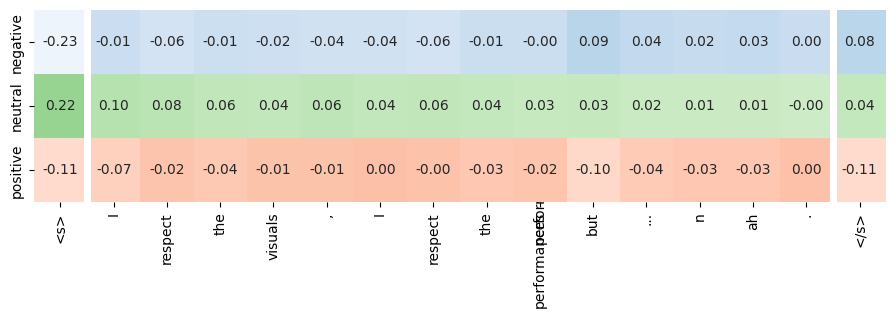

In [80]:
cm = ['Blues', 'Greens', 'Reds']

# plt.figure(figsize=(12, 6))
f, axs = plt.subplots(3, 1, gridspec_kw={'hspace': 0},  figsize=(11, 2.5))

counter = 0
for index, row in data.T.iterrows():
    ax = sns.heatmap(np.array([row.values]), yticklabels=[labels[counter]], xticklabels=data.T.columns, annot=True, fmt='.2f', ax=axs[counter], cmap=cm[counter], cbar=False, vmin=-0.3, vmax=1, linecolor="black")
    ax.axvline(x=1, linewidth=5, color="w")
    ax.axvline(x=len(words) - 1, linewidth=5, color="w")
    counter += 1

plt.show()